In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

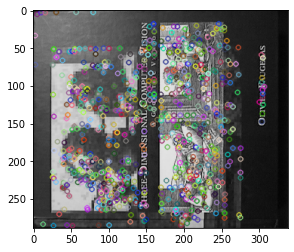

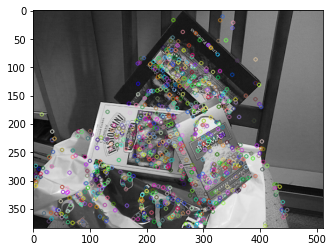

True

In [2]:
# Read images
img1 = cv.imread('book.pgm')
img2 = cv.imread('scene.pgm')

# Create SIFT object
sift = cv.SIFT_create()

# Find and draw keypoints on the image
kp1 = sift.detect(img1, None)
kp2 = sift.detect(img2, None)

img1 = cv.drawKeypoints(img1, kp1, img1)
img2 = cv.drawKeypoints(img2, kp2, img2)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

cv.imwrite('book_keypoints.jpg', img1)
cv.imwrite('scene_keypoints.jpg', img2)

True

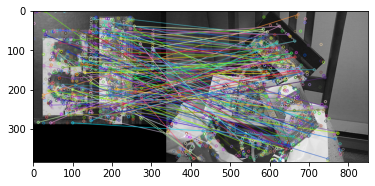

In [3]:
# Compute SIFT descriptors of the keypoints
kp1, des1 = sift.compute(img1, kp1)
kp2, des2 = sift.compute(img2, kp2)

# Match the descriptors
matcher = cv.BFMatcher()
matches = matcher.knnMatch(des1, des2, k=2)

# Ratio test
valid_matches = []
for m, n in matches:
    if m.distance < 0.9 * n.distance:
        valid_matches.append([m])

# Visulization
img_match = cv.drawMatchesKnn(img1, kp1, img2, kp2, valid_matches, None ,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_match)
cv.imwrite('match.jpg', img_match)

ipykernel_launcher:64: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[  0.40269743   0.45099193 134.86923299]
 [ -0.4633691    0.41573416 156.9175265 ]
 [  0.           0.           1.        ]]


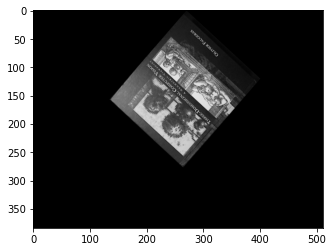

In [4]:
# Convert key points to numpy array
kp1_points = [list(kp1[i].pt) for i in range(len(kp1))]
kp2_points = [list(kp2[i].pt) for i in range(len(kp2))]
kp1_points = np.array(kp1_points)
kp2_points = np.array(kp2_points)

# Convert valid match to numpy array
valid_match_idx = np.array([[valid_matches[i][0].queryIdx, valid_matches[i][0].trainIdx] for i in range(len(valid_matches))])

best_num_inlier = 0
for j in range(100):
    # Randomly choose three sample key points and solve for transformation variables
    sample_index = np.random.choice(valid_match_idx.shape[0], 3)
    sample_kp1 = kp1_points[valid_match_idx[sample_index, 0], :]
    sample_kp2 = kp2_points[valid_match_idx[sample_index, 1], :]

    A = np.array([
        [sample_kp1[0, 0], sample_kp1[0, 1], 1, 0, 0, 0],
        [0, 0, 0, sample_kp1[0, 0], sample_kp1[0, 1], 1],
        [sample_kp1[1, 0], sample_kp1[1, 1], 1, 0, 0, 0],
        [0, 0, 0, sample_kp1[1, 0], sample_kp1[1, 1], 1],
        [sample_kp1[2, 0], sample_kp1[2, 1], 1, 0, 0, 0],
        [0, 0, 0, sample_kp1[2, 0], sample_kp1[2, 1], 1],
    ])
    b = np.array([sample_kp2[0, 0], sample_kp2[0, 1], sample_kp2[1, 0], sample_kp2[1, 1], 
        sample_kp2[2, 0], sample_kp2[2, 1]])
    try:
        parameter = np.linalg.solve(A, b)
    except:
        # print("Singular Matrix")
        continue
    
    # Create the transformation matrix
    transformation = np.array([
        [parameter[0], parameter[1], parameter[2]],
        [parameter[3], parameter[4], parameter[5]],
        [0, 0, 1]
    ])

    # Convert key points to homogeneuous coordinates
    homo_kp1_points = np.concatenate((kp1_points, np.ones((kp1_points.shape[0], 1))), 1)
    homo_kp2_points = np.concatenate((kp2_points, np.ones((kp2_points.shape[0], 1))), 1)

    # Apply transformation and compute the error in euclidean distance
    transformation_error = np.linalg.norm(transformation @ homo_kp1_points[valid_match_idx[:, 0], :].T - homo_kp2_points[valid_match_idx[:, 1], :].T, axis=0)
    num_inlier = np.count_nonzero(transformation_error <= 10)
    # assert()
    
    if num_inlier > best_num_inlier:
        best_num_inlier = num_inlier
        best_transformation = transformation
        inlier_idx = valid_match_idx[transformation_error <= 10, :]
    

# Final fit
A = np.zeros((inlier_idx.shape[0] * 2, 6))
b = np.zeros(inlier_idx.shape[0] * 2)
for i in range(inlier_idx.shape[0]):
    A[2*i, :] = np.array([kp1_points[inlier_idx[i, 0], 0], kp1_points[inlier_idx[i, 0], 1], 1, 0, 0, 0])
    A[2*i+1, :] = np.array([0, 0, 0, kp1_points[inlier_idx[i, 0], 0], kp1_points[inlier_idx[i, 0], 1], 1])
    b[2*i] = kp2_points[inlier_idx[i, 1], 0]
    b[2*i+1] = kp2_points[inlier_idx[i, 1], 1]

parameter = np.linalg.lstsq(A, b)[0]
# print(parameter)
M = np.array([
        [parameter[0], parameter[1], parameter[2]],
        [parameter[3], parameter[4], parameter[5]]
    ])

img1 = cv.imread('book.pgm')
warp = cv.warpAffine(img1, M, (img2.shape[1], img2.shape[0]))
plt.imshow(warp)
cv.imwrite('transformed.jpg', warp)
print(np.array([
        [parameter[0], parameter[1], parameter[2]],
        [parameter[3], parameter[4], parameter[5]],
        [0, 0, 1]
    ]))
    
